In [71]:
import json

import h5py
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from gc_utils import iteration_name, main_prog_halt, snapshot_name  # type: ignore

In [72]:
simulation = "m12i"

sim_dir = "/Users/z5114326/Documents/simulations/"
data_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/"

fire_dir = sim_dir + simulation + "/" + simulation + "_res7100/"

sim = simulation

# proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
# proc_data = h5py.File(proc_file, "a")  # open processed data file

In [73]:
halt = halo.io.IO.read_tree(fire_dir, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt

* read 17859038 halos from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal axes) from:  Users/z5114326/Documents/simulations/m12i/m12i_res7100/track/host_coordinates.hdf5
  host1 position = (41792.15, 44131.23, 46267.68) [kpc comoving]
  host1 velocity = (-52.2, 73.6, 94.7) [km/s]
  host1 axis ratios = (0.16, 0.16, 0.99)


In [74]:
all_snapshot_fil = "/Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt"
with open(all_snapshot_fil) as f:
    content = f.readlines()
    content = content[5:]
snap_all = ascii.read(content)["i"]
tim_all = ascii.read(content)["time[Gyr]"]
lbt_all = ascii.read(content)["lookback-time[Gyr]"]

In [75]:
main_halo_tid = 25236877
tid_main_lst = main_prog_halt(halt, main_halo_tid)

In [76]:
halt.keys()

dict_keys(['am.phantom', 'am.progenitor.main', 'axis.b/a', 'axis.c/a', 'catalog.index', 'central.index', 'central.local.index', 'descendant.index', 'descendant.snapshot', 'dindex', 'final.index', 'host.distance', 'host.index', 'host.velocity', 'host.velocity.rad', 'host.velocity.tan', 'major.merger.snapshot', 'mass', 'mass.180m', 'mass.200c', 'mass.200m', 'mass.500c', 'mass.bound', 'mass.lowres', 'mass.vir', 'position', 'position.offset', 'progenitor.co.dindex', 'progenitor.co.index', 'progenitor.last.dindex', 'progenitor.main.index', 'progenitor.main.last.dindex', 'progenitor.number', 'radius', 'scale.radius', 'scale.radius.klypin', 'snapshot', 'spin.bullock', 'spin.peebles', 'tid', 'vel.circ.max', 'vel.std', 'velocity', 'velocity.offset'])

In [77]:
prog_indices_lst = []
mass_main = []
for tid in tid_main_lst:
    idx = np.where(halt["tid"] == tid)[0][0]
    prog_idxs = halt.prop("progenitor.indices", idx)
    for prog_idx in prog_idxs:
        if (halt["am.progenitor.main"][prog_idx] != 1) & (halt["am.phantom"][prog_idx] == 0):
            prog_indices_lst.append(prog_idx)

In [78]:
# along the major axes R (positive definite)
# azimuthal angle phi (0 to 2 * pi)
# vertical height wrt the disk Z (signed)

In [79]:
snap_lst = []
vr_lst = []
vphi_lst = []
vz_lst = []
mass_Lst = []

for idx in prog_indices_lst:
    v_cyl = halt.prop("host.velocity.principal.cylindrical", idx)
    vr_lst.append(v_cyl[0])
    vphi_lst.append(v_cyl[1])
    vz_lst.append(v_cyl[2])

    mass = halt["mass"][idx]
    mass_Lst.append(mass)

    snap = halt["snapshot"][idx]
    snap_lst.append(snap)

tim_lst = []
for snap in snap_lst:
    idx = np.where(snap_all == snap)[0][0]
    tim = tim_all[idx]
    tim_lst.append(tim)

mass_Lst = np.log10(mass_Lst)

Text(0, 0.5, 'v_z')

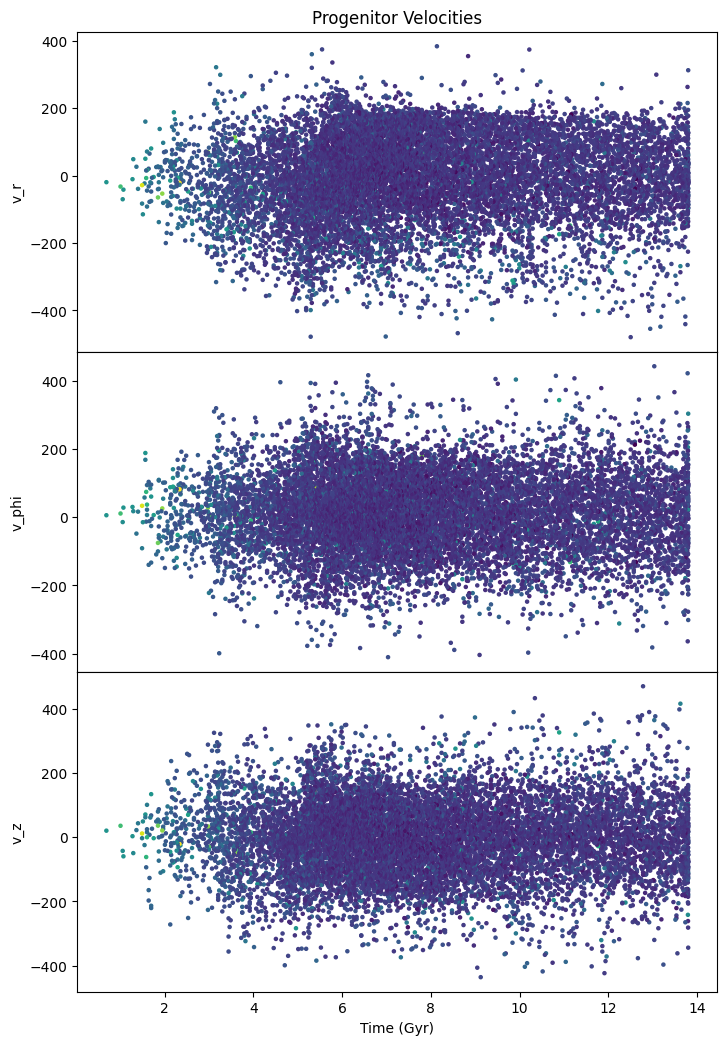

In [85]:
# Create figure and gridspec layout
fig = plt.figure(figsize=(8, 12))

gs = fig.add_gridspec(
    3,
    1,
    # width_ratios=(1, 1, 1),
    height_ratios=(1, 1, 1),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.0,
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

ax0.scatter(tim_lst, vr_lst, s=5, c=mass_Lst)
ax1.scatter(tim_lst, vphi_lst, s=5, c=mass_Lst)
ax2.scatter(tim_lst, vz_lst, s=5, c=mass_Lst)

ax0.set_title("Progenitor Velocities")

ax2.set_xlabel("Time (Gyr)")

ax0.set_ylabel("v_r")
ax1.set_ylabel("v_phi")
ax2.set_ylabel("v_z")

In [88]:
data_dict = {}
for tid in tid_main_lst:
    idx = np.where(halt["tid"] == tid)[0][0]
    snap = halt["snapshot"][idx] - 1
    prog_idxs = halt.prop("progenitor.indices", idx)

    data_dict[str(snap)] = {}

    data_dict[str(snap)]["vr"] = []
    data_dict[str(snap)]["vphi"] = []
    data_dict[str(snap)]["vz"] = []
    data_dict[str(snap)]["mass"] = []

    for prog_idx in prog_idxs:
        if (halt["am.progenitor.main"][prog_idx] != 1) & (halt["am.phantom"][prog_idx] == 0):
            v_cyl = halt.prop("host.velocity.principal.cylindrical", prog_idx)

            data_dict[str(snap)]["vr"].append(v_cyl[0])
            data_dict[str(snap)]["vphi"].append(v_cyl[1])
            data_dict[str(snap)]["vz"].append(v_cyl[2])

            mass = halt["mass"][idx]
            data_dict[str(snap)]["mass"].append(mass)

In [120]:
tim_lst = []
vr_avg_lst = []
vphi_avg_lst = []
vz_avg_lst = []
mass_sum_lst = []

for snap_str in data_dict.keys():
    snap = int(snap_str)

    if len(data_dict[snap_str]["vr"]) != 0:
        vr_avg = np.average(data_dict[snap_str]["vr"], weights=data_dict[snap_str]["mass"])
        vphi_avg = np.average(data_dict[snap_str]["vphi"], weights=data_dict[snap_str]["mass"])
        vz_avg = np.average(data_dict[snap_str]["vz"], weights=data_dict[snap_str]["mass"])

        vr_avg_lst.append(vr_avg)
        vphi_avg_lst.append(vphi_avg)
        vz_avg_lst.append(vz_avg)

        mass_sum_lst.append(np.sum(data_dict[snap_str]["mass"]))

        idx = np.where(snap_all == snap)[0][0]
        tim = tim_all[idx]
        tim_lst.append(tim)

Text(0, 0.5, 'v_z')

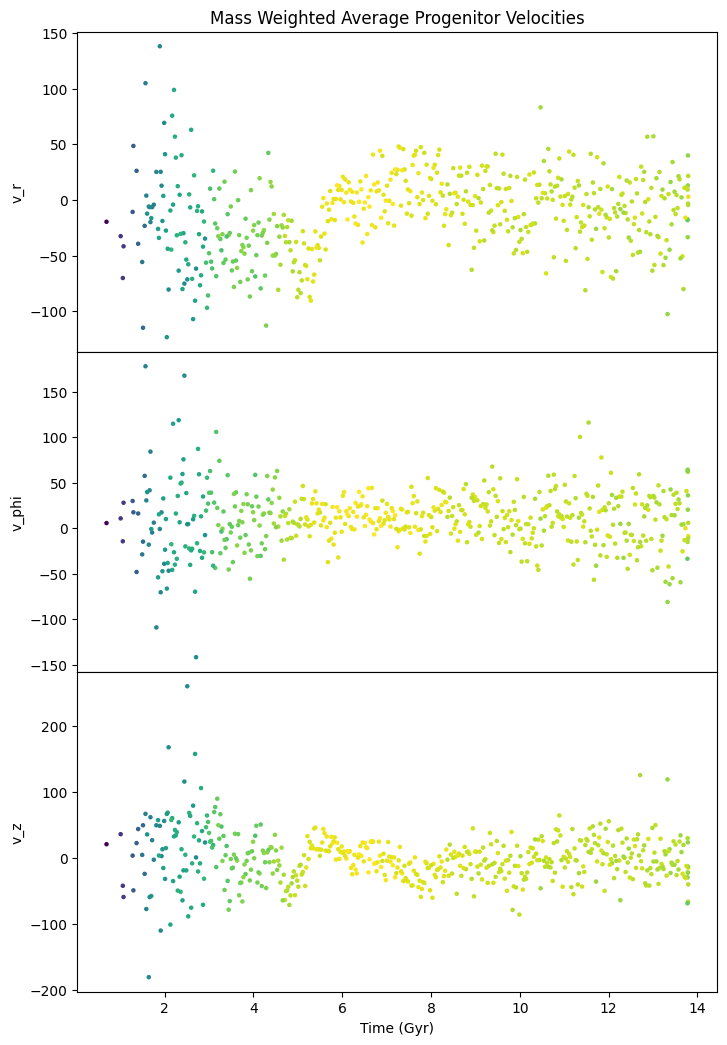

In [121]:
# Create figure and gridspec layout
fig = plt.figure(figsize=(8, 12))

gs = fig.add_gridspec(
    3,
    1,
    # width_ratios=(1, 1, 1),
    height_ratios=(1, 1, 1),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.0,
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

mass_log_list = np.log10(mass_sum_lst)

ax0.scatter(tim_lst, vr_avg_lst, s=5, c=mass_log_list)
ax1.scatter(tim_lst, vphi_avg_lst, s=5, c=mass_log_list)
ax2.scatter(tim_lst, vz_avg_lst, s=5, c=mass_log_list)

ax0.set_title("Mass Weighted Average Progenitor Velocities")

ax2.set_xlabel("Time (Gyr)")

ax0.set_ylabel("v_r")
ax1.set_ylabel("v_phi")
ax2.set_ylabel("v_z")

In [133]:
snap_lst = []
lz_lst = []
mass_lst = []

for idx in prog_indices_lst:
    vel = halt.prop("host.velocity.principal", idx)
    pos = halt.prop("host.distance.principal", idx)

    lz = pos[0] * vel[1] - pos[1] * vel[0]
    snap = halt["snapshot"][idx]

    mass_lst.append(halt["mass"][idx])

    snap_lst.append(snap)
    lz_lst.append(lz)

tim_lst = []
for snap in snap_lst:
    idx = np.where(snap_all == snap)[0][0]
    tim = tim_all[idx]
    tim_lst.append(tim)

Text(0, 0.5, 'Lz')

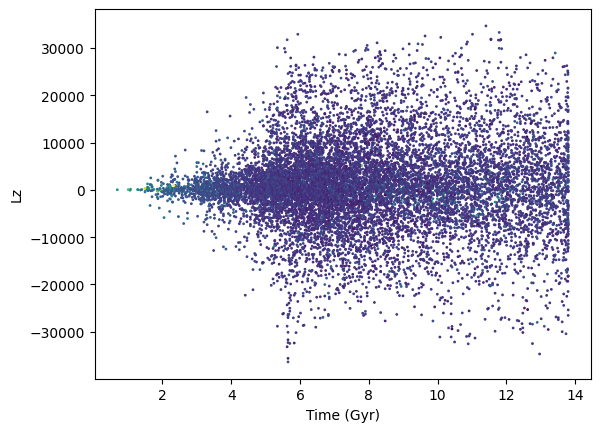

In [136]:
plt.scatter(tim_lst, lz_lst, c=mass_Lst, s=1)
plt.xlabel("Time (Gyr)")
plt.ylabel("Lz")

In [148]:
snap_pull = []

mass_new_lst = []
lz_new_lst = []

for snap in snap_lst:
    if snap not in snap_pull:
        snap_pull.append(snap)

mass_weight_lz = []
for snap in snap_pull:
    mask = np.array(snap_lst) == snap

    mass_new = np.array(mass_lst)[mask]
    lz_new = np.array(lz_lst)[mask]

    lz_avg = np.average(lz_new, weights=mass_new)
    mass_sum = np.sum(mass_new)

    lz_new_lst.append(lz_avg)
    mass_new_lst.append(mass_sum)

tim_lst = []
for snap in snap_pull:
    idx = np.where(snap_all == snap)[0][0]
    tim = tim_all[idx]
    tim_lst.append(tim)

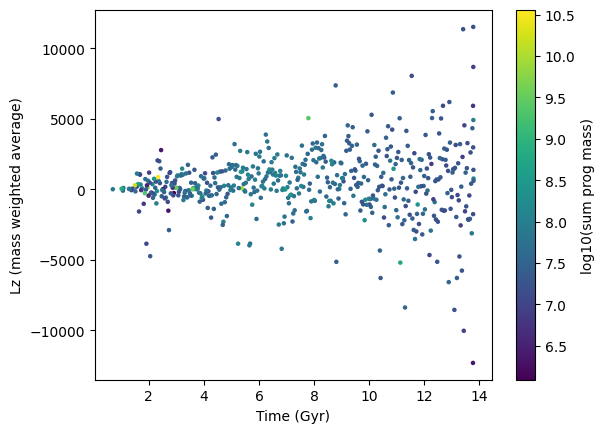

In [155]:
plt.scatter(tim_lst, lz_new_lst, c=np.log10(mass_new_lst), s=5)
plt.xlabel("Time (Gyr)")
plt.ylabel("Lz (mass weighted average)")
plt.colorbar(label="log10(sum prog mass)")